In [1]:
from transformers import ASTFeatureExtractor, AutoProcessor
import librosa
import zipfile
import torch
from transformers import AutoProcessor
import os
import glob
from tqdm import tqdm
from transformers import ASTConfig, ASTModel
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
from transformers import ASTForAudioClassification, Trainer, TrainingArguments

In [2]:
# Check if a GPU is available and set the device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU 🟢")
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU 🟡")

PyTorch is using GPU 🟢


In [3]:
cwd = os.getcwd()
cwd

'/home/euanggg16/euanggg/modeling'

In [4]:
os.chdir('..')

In [5]:
new_cwd = os.getcwd()
new_cwd

'/home/euanggg16/euanggg'

In [6]:
dir_path = next(os.walk(new_cwd))[1]
dir_path

['.ipynb_checkpoints', 'modeling', 'dataset']

In [8]:
dir_path_audio = new_cwd +'/dataset/set 2.2'
os.path.exists(dir_path_audio)

True

In [9]:
class_name = next(os.walk(dir_path_audio))[1]
class_name.remove('.ipynb_checkpoints')
class_name

['tired', 'hungry', 'bpain', 'discomfort']

In [10]:
audio_dir = [os.path.join(dir_path_audio, name) for name in class_name]
audio_dir

['/home/euanggg16/euanggg/dataset/set 2.2/tired',
 '/home/euanggg16/euanggg/dataset/set 2.2/hungry',
 '/home/euanggg16/euanggg/dataset/set 2.2/bpain',
 '/home/euanggg16/euanggg/dataset/set 2.2/discomfort']

In [11]:
bpain_audio = glob.glob(os.path.join(audio_dir[2], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_dir[3], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_dir[1], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_dir[0], '*.wav'))

In [12]:
len(tired_audio)

49

In [13]:
audio_path_class = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

## **테스트 데이터**

In [14]:
test_dir = new_cwd +'/dataset/test'
os.path.exists(test_dir)

True

In [15]:
class_name_test = next(os.walk(test_dir))[1]
class_name_test

['bellypain', 'tired', 'hungry', 'discomfort']

In [16]:
audio_dir_test = [os.path.join(test_dir, name) for name in class_name_test]
audio_dir_test

['/home/euanggg16/euanggg/dataset/test/bellypain',
 '/home/euanggg16/euanggg/dataset/test/tired',
 '/home/euanggg16/euanggg/dataset/test/hungry',
 '/home/euanggg16/euanggg/dataset/test/discomfort']

In [17]:
bpain_audio_test = glob.glob(os.path.join(audio_dir_test[0], '*.wav'))
discomf_audio_test = glob.glob(os.path.join(audio_dir_test[3], '*.wav'))
hungry_audio_test = glob.glob(os.path.join(audio_dir_test[2], '*.wav'))
tired_audio_test = glob.glob(os.path.join(audio_dir_test[1], '*.wav'))

In [18]:
len(tired_audio_test)

10

In [19]:
test_path_class = {
    'bpain': bpain_audio_test,
    'discomf': discomf_audio_test,
    'hungry': hungry_audio_test,
    'tired': tired_audio_test
}

## **Librosa로 오디오 불러오기**

In [20]:
def convert_audio(pathdict):
    audio_load = {}

    for class_name, path in tqdm(pathdict.items()):
        temp = []
        for file in path:
            audio, sr = librosa.load(file, sr = 16000)
            temp.append(audio)
        audio_load[class_name] = temp
    return audio_load

In [21]:
loaded_audio = convert_audio(audio_path_class)

100%|█████████████████████████████████████| 4/4 [00:03<00:00,  1.05it/s]


In [22]:
len(loaded_audio['tired'])

49

In [23]:
test_audio = convert_audio(test_path_class)

100%|█████████████████████████████████████| 4/4 [00:00<00:00, 33.80it/s]


In [24]:
# test_audio

## **AutoProcessor 불러오기**

In [25]:
processor = AutoProcessor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


## **훈련데이터 만들기**

In [26]:
input_byclass = {}
for class_name, audio_load in loaded_audio.items():
    temp = []
    for audio in audio_load:
        input = processor(audio, sampling_rate = 16000, return_tensor = 'pt')
        temp.append(input['input_values'])
    input_byclass[class_name] = np.array(temp)

In [27]:
list(enumerate(input_byclass))

[(0, 'bpain'), (1, 'discomf'), (2, 'hungry'), (3, 'tired')]

In [28]:
np.full(10, np.inf)

array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])

In [29]:
all_data = []
all_labels = []
for label, class_data in enumerate(input_byclass):
    all_data.append(input_byclass[class_data])  # Append class data
    all_labels.append(np.full(len(input_byclass[class_data]), label))

In [30]:
len(all_data)

4

In [31]:
len(all_labels)

4

In [32]:
# data 1
rand = np.random.randint(10, size = (2, 5, 5))
# data 2
rand2 = np.random.randint(10, size = (2, 5, 5))

In [33]:
lst = [rand, rand2]
np.concatenate(lst, axis = 0)

array([[[5, 4, 7, 9, 3],
        [2, 6, 7, 1, 0],
        [9, 0, 1, 9, 7],
        [4, 9, 8, 0, 6],
        [2, 7, 4, 1, 2]],

       [[1, 3, 7, 2, 2],
        [1, 4, 3, 9, 0],
        [8, 8, 0, 3, 2],
        [5, 0, 2, 3, 5],
        [6, 2, 3, 7, 5]],

       [[2, 9, 5, 5, 4],
        [0, 3, 2, 4, 7],
        [0, 7, 2, 3, 6],
        [0, 7, 8, 9, 8],
        [8, 1, 3, 0, 2]],

       [[0, 5, 3, 4, 2],
        [6, 9, 2, 6, 4],
        [4, 2, 2, 2, 6],
        [2, 9, 0, 4, 9],
        [9, 2, 0, 2, 0]]])

In [34]:
rand

array([[[5, 4, 7, 9, 3],
        [2, 6, 7, 1, 0],
        [9, 0, 1, 9, 7],
        [4, 9, 8, 0, 6],
        [2, 7, 4, 1, 2]],

       [[1, 3, 7, 2, 2],
        [1, 4, 3, 9, 0],
        [8, 8, 0, 3, 2],
        [5, 0, 2, 3, 5],
        [6, 2, 3, 7, 5]]])

In [35]:
all_data = np.concatenate(all_data, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [36]:
print(all_data.shape)
print(all_labels.shape)

(340, 1, 1024, 128)
(340,)


In [37]:
# Convert to PyTorch tensors
all_data_tensor = torch.tensor(all_data, dtype=torch.float32)
all_labels_tensor = torch.tensor(all_labels, dtype=torch.long)

In [38]:
squeezed_data = all_data_tensor.squeeze(1)

In [39]:
all_data_tensor.shape

torch.Size([340, 1, 1024, 128])

In [40]:
all_labels_tensor.shape

torch.Size([340])

In [41]:
dataset = TensorDataset(squeezed_data, all_labels_tensor)

#Determine the size of each split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

#Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## **테스트 데이터셋 만들기**

In [42]:
test_byclass = {}
for class_name, audio_load in test_audio.items():
    temp = []
    for audio in audio_load:
        input = processor(audio, sampling_rate = 16000, return_tensor = 'pt')
        temp.append(input['input_values'])
    test_byclass[class_name] = np.array(temp)

In [43]:
test_data = []
test_labels = []
for label, class_data in enumerate(test_byclass):
    test_data.append(test_byclass[class_data])  # Append class data
    test_labels.append(np.full(len(test_byclass[class_data]), label))

In [44]:
test_data[0].shape

(10, 1, 1024, 128)

In [45]:
test_data_a = np.concatenate(test_data, axis=0)
test_labels_a = np.concatenate(test_labels, axis=0)

In [46]:
print(test_data_a.shape)
print(test_labels_a.shape)

(40, 1, 1024, 128)
(40,)


In [47]:
# Convert to PyTorch tensors
test_data_tensor = torch.tensor(test_data_a, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels_a, dtype=torch.long)

In [48]:
test_data_tensor.shape

torch.Size([40, 1, 1024, 128])

In [49]:
squeezed_test = test_data_tensor.squeeze(1)

In [50]:
squeezed_test.shape

torch.Size([40, 1024, 128])

In [51]:
test_labels_tensor.shape

torch.Size([40])

In [52]:
test_data_tensor.shape

torch.Size([40, 1, 1024, 128])

In [53]:
testset = TensorDataset(squeezed_test, test_labels_tensor)
test_loader = DataLoader(testset, batch_size=8, shuffle=True)

## **모델 불러오기**

ast.encoder.layer.11
layernorm

In [54]:
import torch.nn as nn

class CustomASTClassifier(nn.Module):
    def __init__(self, ast_model_name, num_labels):
        super().__init__()
        self.ast = ASTModel.from_pretrained(ast_model_name)

        for param in self.ast.parameters():
            param.requires_grad = False

        # ft_layer_01 = 'ast.encoder.layer.11'
        # ft_layer_02 = 'ast.encoder.layer.10'  # Example, adjust based on actual layer name
        # for name, param in self.ast.named_parameters():
        #     if ft_layer_01 in name or ft_layer_02 in name:
        #         param.requires_grad = True

        # Adding a dense layer for classification
        self.classifier = nn.Linear(self.ast.config.hidden_size, 48)
        self.add_layer_01 = nn.Linear(48, num_labels)
        self.num_labels = num_labels  # Define num_labels as an attribute

    def forward(self, input_values, labels=None):
        outputs = self.ast(input_values)
        embeddings = outputs.last_hidden_state
        logits = self.classifier(embeddings.mean(dim=1))
        logits = self.add_layer_01(logits)
        # Add further logic for calculating loss if labels are provided
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss, logits
        return logits

In [55]:
import torch.optim as optim
import matplotlib.pyplot as plt

num_labels = 4
ast_model_name = "MIT/ast-finetuned-audioset-10-10-0.4593"
model = CustomASTClassifier(ast_model_name, num_labels).to(device)

# Define your optimizer, loss function, etc.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize metric lists
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

In [56]:
# Training loop
for epoch in range(250):
    total_loss, correct, total = 0, 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    # Training phase
    for batch in train_loader:
        optimizer.zero_grad()
        input_values, labels = batch
        input_values, labels = input_values.to(device), labels.to(device)

        loss, logits = model(input_values, labels)
        total_loss += loss.item()

        # Calculate accuracy
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    if val_loader is not None:
        model.eval()
        with torch.no_grad():
            val_loss, correct, total = 0, 0, 0
            for batch in val_loader:
                input_values, labels = batch
                input_values, labels = input_values.to(device), labels.to(device)

                loss, logits = model(input_values, labels)
                val_loss += loss.item()
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            val_accuracy = correct / total
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        model.train()

Epoch 1:   0%|                        | 0/34 [00:23<?, ?it/s, loss=1.33]

Epoch 3:   0%|                       | 0/34 [00:18<?, ?it/s, loss=0.992]

Epoch 5:   0%|                       | 0/34 [00:19<?, ?it/s, loss=0.867]

Epoch 7:   0%|                       | 0/34 [00:20<?, ?it/s, loss=0.707]

Epoch 9:   0%|                       | 0/34 [00:20<?, ?it/s, loss=0.525]

Epoch 11:   0%|                      | 0/34 [00:20<?, ?it/s, loss=0.898]

Epoch 13:   0%|                      | 0/34 [00:20<?, ?it/s, loss=0.452]

Epoch 15:   0%|                      | 0/34 [00:20<?, ?it/s, loss=0.548]

Epoch 17:   0%|                      | 0/34 [00:20<?, ?it/s, loss=0.336]

Epoch 19:   0%|                      | 0/34 [00:20<?, ?it/s, loss=0.355]

Epoch 21:   0%|                      | 0/34 [00:20<?, ?it/s, loss=0.144]

Epoch 23:   0%|                      | 0/34 [00:20<?, ?it/s, loss=0.415]

Epoch 25:   0%|                     | 0/34 [00:20<?, ?it/s, loss=0.0278]

Epoch 27:   0%|                     | 

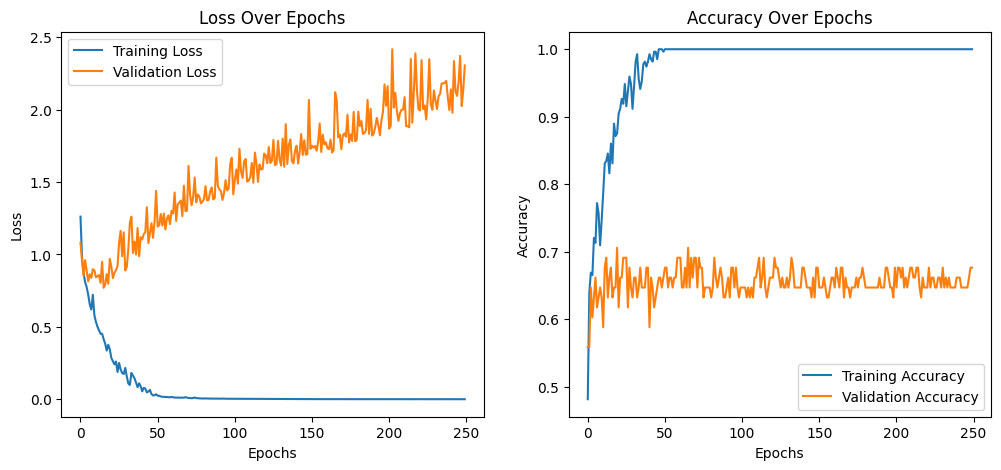

In [57]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
if val_loader is not None:
    plt.plot(val_losses, label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
if val_loader is not None:
    plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('epc250_unit48.png')

plt.show()

In [58]:
all_data_tensor.shape

torch.Size([340, 1, 1024, 128])

In [59]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation
    for data in test_loader:  # dataloader is your DataLoader for the dataset
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 75.00%


In [ ]:
# Save the model
model_path = "ast_classifer01.pth"
torch.save(model.state_dict(), model_path)